<h1><b>인공지능개론 5주차 과제2(heart.csv)<br></b></h1>
<p>컴퓨터공학과 202136038 조성준</p>


---

<h1><b>1. 딥러닝 분류(heart.csv)<br></b></h1>

---



<h2><b>1-0. 라이브러리 import(분류)</b></h2>

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

#하이퍼 파라미터 튜닝
!pip install -q keras-tuner
from kerastuner.tuners import RandomSearch
from keras_tuner import HyperParameters

#딥러닝 관련
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import SGD,Adam

import numpy as np


<h2><b>1-1. 데이터 로딩</b></h2>

In [25]:
# url을 통해 CSV 파일 읽기
url = "https://raw.githubusercontent.com/MyungKyuYi/AI-class/refs/heads/main/heart.csv" #kc_house_data.csv의 url입력
df = pd.read_csv(url)

# 데이터프레임 확인
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [26]:
# 컬렴명 확인
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


<h2><b>1-2. 결측치 확인</b></h2>

In [27]:
# 결측치 확인
print(df.isnull().sum())
# 확인 결과: 결측치가 확인되지않음

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


<h2><b>1-3. 레이블 확인(imbalanced data)</b></h2>
<li>타겟 변수(target)의 분포를 확인</li>

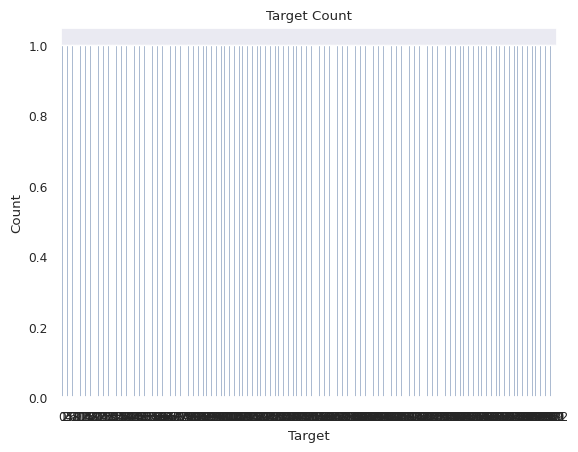

,count
target,
1,165
0,138


In [28]:
# 레이블 갯수 확인 (그래프)
sns.countplot(df['target'])
plt.xlabel("Target")
plt.ylabel("Count")
plt.title("Target Count")
plt.show()

# 레이블 갯수 확인 (숫자)
df['target'].value_counts()


<h2><b>1-4. 데이터 전처리</b></h2>

In [29]:
#1. 데이터 불러오기는 이미 위에서 실향
#2. 불필요한 열 제거 -> 굳이 제거해야할 열 X

#3. 타겟 변수와 입력 변수 분리
X = df.drop(columns=['target'])
y = df['target']

#4. 범주형 데이터 원-핫 인코딩
X = pd.get_dummies(X, columns=['cp', 'restecg', 'slope', 'thal'], drop_first=True)

#5. 학습/테스트 데이터 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#6. 특성 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#7. 확인
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (242, 19)
X_test shape: (61, 19)
y_train shape: (242,)
y_test shape: (61,)


<h2><b>1-5. 모델 구성&컴파일(하이퍼 파라미터 튜닝을 이용하여)</b></h2>

In [30]:
# 1. 모델 생성 함수 정의
def build_model(hp):
    model = Sequential()
    model.add(Dense(hp.Int('units1', min_value=32, max_value=256, step=32),
                    activation='relu',
                    input_shape=(X_train.shape[1],)))
    model.add(Dense(hp.Int('units2', min_value=16, max_value=128, step=16),
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  #이진분류는 sigmoid

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
        ),
        loss='binary_crossentropy', #이진분류용
        metrics=['accuracy']
    )
    return model

# 2. HyperParameters 수동 설정
hp = HyperParameters()
hp.values['units1'] = 64
hp.values['units2'] = 32
hp.values['learning_rate'] = 0.001

# 3. 모델 생성 및 요약 출력
model = build_model(hp)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

<h2><b>1-6. 모델 학습 </b></h2>

In [31]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.4965 - loss: 0.7216 - val_accuracy: 0.6327 - val_loss: 0.6936
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5753 - loss: 0.6517 - val_accuracy: 0.6327 - val_loss: 0.6320
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7650 - loss: 0.5788 - val_accuracy: 0.7143 - val_loss: 0.5861
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7748 - loss: 0.5574 - val_accuracy: 0.7347 - val_loss: 0.5554
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7867 - loss: 0.5338 - val_accuracy: 0.7347 - val_loss: 0.5295
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7947 - loss: 0.5044 - val_accuracy: 0.7551 - val_loss: 0.5086
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8689 - loss: 0.4713 - val_accuracy: 0.8367 - val_loss: 0.4894
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8184 - loss: 0.4752 - val_accuracy: 0.8163 - val_loss

<h2><b>1-7. 시각화 </b></h2>

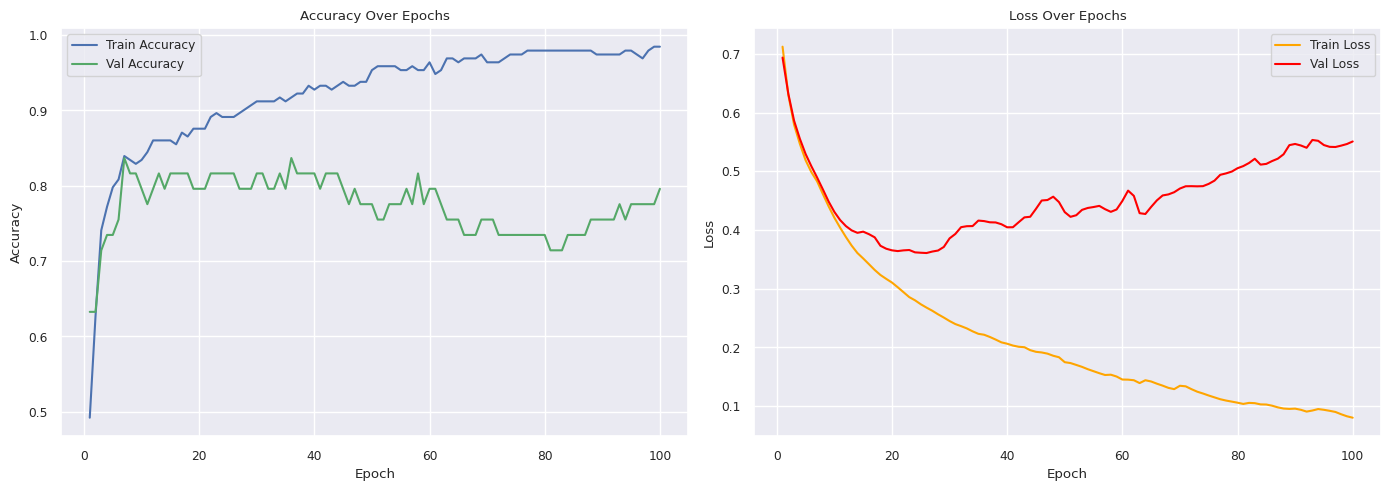

In [32]:
# 데이터 불러오기
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Subplot 생성
plt.figure(figsize=(14, 5))

# Accuracy 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'orange', label='Train Loss')
plt.plot(epochs, val_loss, 'red', label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


<h2><b>1-8. 예측 및 시각화(회귀=산점도, 이진분류=혼동행렬)</b></h2>

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


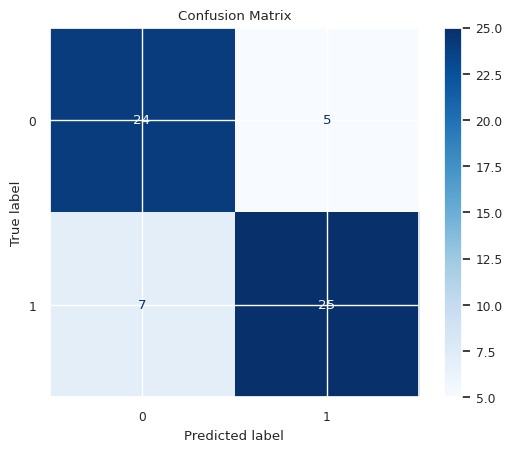

In [33]:
#이진분류이므로 혼동행렬 시각화
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 확률 → 클래스로 변환
y_pred_class = (model.predict(X_test) > 0.5).astype(int)

# 혼동 행렬
cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

<h2><b>1-9. 결과 평가 </b></h2>

In [34]:
#classification report
print(classification_report(y_test, y_pred_class))



              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.83      0.78      0.81        32

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61

